# Проект для "Викишоп"

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.\
Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.\
Нужно построить модель со значением метрики качества F1 не меньше 0.75. 

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm.notebook import trange, tqdm
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from pymystem3 import Mystem
import nltk
nltk.download('stopwords')
#from sklearn import *
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка и подготовка данных

In [18]:
try:
    df = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Проект. Машинное обучение на текстах/toxic_comments.csv',
                    index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [19]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [21]:
df.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<AxesSubplot:>

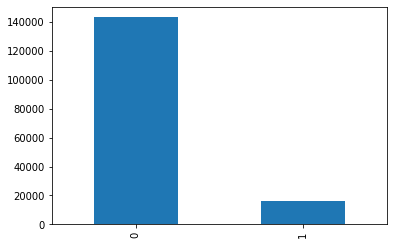

In [22]:
df['toxic'].value_counts().plot(kind='bar')

In [23]:
#функция обработки текста
def clear_data(text):
    text = text.lower() #приведение к нижнему регистру
    
    text = re.sub(r"(?:\n|\r)", " ", text) #замена специальных символов на пробел
    text = re.sub(r"[^a-zA-Z' ]+", " ", text).strip() #удаление всех символов, которые не являются буквами или пробелами
    text = re.sub(r'\s+', ' ', text, flags=re.I) #удаление лишних пробелов
    return text

In [24]:
df['text'] = df['text'].apply(clear_data)
display(df.head())

,text,toxic
0,explanation why the edits made under my userna...,0
1,d'aww he matches this background colour i'm se...,0
2,hey man i'm really not trying to edit war it's...,0
3,more i can't make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Загрузив и проанализировав все данные, необходимо было также обработать текст в признаках.\
- Все символы приведены к нижнему регистру;
- Специальные символы заменены на пробелы;
- Удалены все лишние символы, которые не являются буквами или пробелами;
- Также после замены всех символы образовались лишние пробелы, которые также были удалены.

## Деление на подвыборки

In [25]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=12345)

features_train = df_train.drop('toxic', axis=1)
target_train = df_train['toxic']

features_test = df_test.drop('toxic', axis=1)
target_test = df_test['toxic']

print('Полученные размерности выборок:')
print(f'train: {df_train.shape[0]}({round(len(df_train)/len(df) * 100)}%)\ntest: {df_test.shape[0]}({round(len(df_test)/len(df) * 100)}%)')

Полученные размерности выборок:
train: 143362(90%)
test: 15930(10%)


In [26]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('averaged_perceptron_tagger')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
train_corpus = df_train['text'].values

In [28]:
for i in trange(train_corpus.shape[0]):
    train_corpus[i] = lemmatize_sent(train_corpus[i])
    train_corpus[i] = ' '.join(train_corpus[i])

  0%|          | 0/143362 [00:00<?, ?it/s]

In [29]:
#train_corpus = ' '.join(train_corpus)
train_corpus

array(['latin on august you ask on my talkpage whether i could help you with translate something into latin you never tell me what however',
       "this be n't base off of a cure song sometimes the band be compare stylistically to the cure but that 's where the similarity end",
       'i think your position be very weird this be about english people not about american what do you imply that the majority of people in england descend from the th century i will just leave it here for other people to judge but beleive me your position be among the most weird one that i have see up to now',
       ...,
       "agree we really should try to stick to the subject of the article at hand and look through the jeremy clarkson article i see there really be n't a lot about his penchant for speed it 's mention but just briefly alongside his clean driving record however in search via google i find this article http drive timesonline co uk article html this to me seem rather strike to have somebody ta

In [30]:
test_corpus = df_test['text'].values

In [31]:
for i in trange(test_corpus.shape[0]):
    test_corpus[i] = lemmatize_sent(test_corpus[i])
    test_corpus[i] = ' '.join(test_corpus[i])

  0%|          | 0/15930 [00:00<?, ?it/s]

In [32]:
test_corpus

array(['expert categorizers why be there no mention of the fact that nazis be particularly great categorizers they excel in identify various thing and write about them and put them in their proper place',
       'noise fart talk',
       'an indefinite block be appropriate even for a minor infraction if you show know sign of discontinue talk',
       ...,
       "july utc well i suppose the question on the table be this do we want to be rational or irrational my answer be obvious but i 'll carry the discussion a little further libertarian be interested in the social situation of their environment but be they interested in the social situation of their environment a a whole that would be a subject under the purview of socialism would n't it shepherd of commerce and discourse do your bad please",
       "i agree with this person 's comment how blatantly these two editor subhash and baka say they be not liberal and secular and carry on edits to support organisation that india 's first pri

In [33]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,1))
tf_idf_train = count_tf_idf.fit_transform(train_corpus)

In [37]:
tf_idf_test = count_tf_idf.transform(test_corpus)

Данные были разделены на выборки, в соотношении 80:10:10 (train:valid:test).\
Далее все выборки были лемматизированы, с помощью библиотеки pymystem3.

## Обучение различных моделей

##### LogisticRegression

In [122]:
#%%time
#lr = LogisticRegression(random_state=12345, solver='liblinear', max_iter=100)
#params = {
#   'penalty':['l1', 'l2'],        
#   'C':list(range(1, 10, 2)) 
#}

#lr_gs = GridSearchCV(lr, params, cv=3, scoring='f1', verbose=3, n_jobs=-1).fit(tf_idf_train, target_train)

#print ("Best Params", lr_gs.best_params_)
#print ("Best Score", lr_gs.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ................................C=1, penalty=l1; total time=   0.9s
[CV 2/3] END ................................C=1, penalty=l1; total time=   0.8s
[CV 3/3] END ................................C=1, penalty=l1; total time=   0.8s
[CV 1/3] END ................................C=1, penalty=l2; total time=   7.1s
[CV 2/3] END ................................C=1, penalty=l2; total time=   7.3s
[CV 3/3] END ................................C=1, penalty=l2; total time=   7.6s
[CV 1/3] END ................................C=3, penalty=l1; total time=   1.2s
[CV 2/3] END ................................C=3, penalty=l1; total time=   1.1s
[CV 3/3] END ................................C=3, penalty=l1; total time=   1.1s
[CV 1/3] END ................................C=3, penalty=l2; total time=  11.0s
[CV 2/3] END ................................C=3, penalty=l2; total time=  10.2s
[CV 3/3] END ................................C=3

In [44]:
pipeline = Pipeline(
    [
        ('model', LogisticRegression(max_iter=100, random_state=12345))
    ]
)

In [45]:
param_distributions = {
    'model__C': list(range(7, 10, 2)),
    'model__penalty': ['l1', 'l2'],
}

In [46]:
random_search_lr = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    random_state=12345,
    scoring='f1',
    n_jobs=-1,
    verbose=3,
).fit(tf_idf_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..................model__C=7, model__penalty=l1; total time=   0.0s
[CV 2/5] END ..................model__C=7, model__penalty=l1; total time=   0.0s
[CV 3/5] END ..................model__C=7, model__penalty=l1; total time=   0.0s
[CV 4/5] END ..................model__C=7, model__penalty=l1; total time=   0.0s
[CV 5/5] END ..................model__C=7, model__penalty=l1; total time=   0.0s
[CV 1/5] END ..................model__C=7, model__penalty=l2; total time=  47.9s
[CV 2/5] END ..................model__C=7, model__penalty=l2; total time=  46.2s
[CV 3/5] END ..................model__C=7, model__penalty=l2; total time=  45.0s
[CV 4/5] END ..................model__C=7, model__penalty=l2; total time=  50.0s
[CV 5/5] END ..................model__C=7, model__penalty=l2; total time=  50.3s
[CV 1/5] END ..................model__C=9, model__penalty=l1; total time=   0.0s
[CV 2/5] END ..................model__C=9, model_

In [47]:
print("Best parameters found:", random_search_lr.best_params_)
print("Best f1 score:", random_search_lr.best_score_)

Best parameters found: {'model__penalty': 'l2', 'model__C': 9}
Best f1 score: 0.7661780629648409


##### RandomForestClassifier

In [144]:
pipeline = Pipeline(
    [
        ('model', RandomForestClassifier(random_state=12345))
    ]
)

In [145]:
param_distributions = {
    'model__n_estimators': [10],
    'model__max_depth': [None, 10]
}

In [146]:
random_search_rf = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    random_state=12345,
    scoring='f1',
    n_jobs=-1,
    verbose=3,
).fit(tf_idf_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ..model__max_depth=None, model__n_estimators=10; total time= 1.7min
[CV 2/5] END ..model__max_depth=None, model__n_estimators=10; total time= 1.7min
[CV 3/5] END ..model__max_depth=None, model__n_estimators=10; total time= 1.7min
[CV 4/5] END ..model__max_depth=None, model__n_estimators=10; total time= 1.7min
[CV 5/5] END ..model__max_depth=None, model__n_estimators=10; total time= 1.7min
[CV 1/5] END ....model__max_depth=10, model__n_estimators=10; total time=   2.4s
[CV 2/5] END ....model__max_depth=10, model__n_estimators=10; total time=   2.4s
[CV 3/5] END ....model__max_depth=10, model__n_estimators=10; total time=   2.5s
[CV 4/5] END ....model__max_depth=10, model__n_estimators=10; total time=   2.5s
[CV 5/5] END ....model__max_depth=10, model__n_estimators=10; total time=   2.4s


In [147]:
print("Best parameters found:", random_search_rf.best_params_)
print("Best f1 score:", random_search_rf.best_score_)

Best parameters found: {'model__n_estimators': 10, 'model__max_depth': None}
Best f1 score: 0.646643055055265


In [216]:
#%%time
#rf = RandomForestClassifier(random_state=12345)
#params = {
#   'n_estimators':list(range(10, 100, 10)),        
#   'max_depth':list(range(1,30, 2)) 
#}

#rf_gs = GridSearchCV(rf, params, cv=3, scoring='f1', verbose=3, n_jobs=-1).fit(tf_idf_train, target_train)

#print ("Best Params", rf_gs.best_params_)
#print ("Best Score", rf_gs.best_score_)

Fitting 3 folds for each of 135 candidates, totalling 405 fits
Best Params {'max_depth': 29, 'n_estimators': 10}
Best Score 0.026830704514663985
Wall time: 44min 45s


##### CatBoostClassifier

In [38]:
pipeline = Pipeline(
    [
        ('model', CatBoostClassifier(random_state=12345))
    ]
)

In [39]:
param_distributions = {
    'model__iterations': [10],
    'model__learning_rate': [0.1],
    'model__depth': [3],
    'model__l2_leaf_reg': [1] 
}

In [42]:
random_search_cb = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    random_state=12345,
    scoring='f1',
    n_jobs=-1,
    verbose=3,
).fit(tf_idf_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.5950123	total: 933ms	remaining: 8.4s
1:	learn: 0.5199578	total: 1.74s	remaining: 6.94s
2:	learn: 0.4604328	total: 2.56s	remaining: 5.98s
3:	learn: 0.4155886	total: 3.4s	remaining: 5.1s
4:	learn: 0.3804955	total: 4.26s	remaining: 4.26s
5:	learn: 0.3526596	total: 5.09s	remaining: 3.39s
6:	learn: 0.3313999	total: 5.94s	remaining: 2.54s
7:	learn: 0.3149413	total: 6.76s	remaining: 1.69s
8:	learn: 0.3016184	total: 7.58s	remaining: 842ms
9:	learn: 0.2908188	total: 8.39s	remaining: 0us
[CV 1/5] END model__depth=3, model__iterations=10, model__l2_leaf_reg=1, model__learning_rate=0.1; total time=  53.5s
0:	learn: 0.5952319	total: 992ms	remaining: 8.93s
1:	learn: 0.5231626	total: 1.89s	remaining: 7.58s
2:	learn: 0.4636910	total: 2.81s	remaining: 6.56s
3:	learn: 0.4173783	total: 3.69s	remaining: 5.53s
4:	learn: 0.3821951	total: 4.56s	remaining: 4.56s
5:	learn: 0.3556781	total: 5.4s	remaining: 3.6s
6:	learn: 0.3334461	total: 6.2

In [43]:
print("Best parameters found:", random_search_cb.best_params_)
print("Best f1 score:", random_search_cb.best_score_)

Best parameters found: {'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1, 'model__iterations': 10, 'model__depth': 3}
Best f1 score: 0.40999390890282433


В ходе анализа различных моделей, были обучены следующие:\
- LogisticRegression с результатом метрики f1_score = 0.767, что удовлетворяет условию f1 > 0.75;
- RandomForestClassifier с результатом метрики f1_score = 0.64, что не удовлетворяет условию f1 > 0.75;
- CatBoostClassifier с результатом метрики f1_score = 0.4, что не удовлетворяет условию f1 > 0.75.

По итогу, лучший результат был получен на модели LogisticRegression, которая и будет использована для дальнейшей проверки не тестовой выборке.

## Проверка лучшей модели на тестовой выборке и выводы

In [49]:
model_pred = random_search_lr.predict(tf_idf_test)
test_score = f1_score(target_test, model_pred)
test_score

0.7792479108635098

<div style="border:solid orange 2px; padding: 20px">

## Вывод

В ходе работы над проектом были проделаны следующие действия:
- Загружен датасет и проанализирован;
- Данные были предобработаны для дальнейшей работы, путем очистки от лишних символов;
- Текст в признаках был лемматизирован;
- Далее данные были разбиты на выборки, в соотношении 90:10 (train:test);
- Были обучены модели логистической регрессии, случайного леса и catboost;
- Лучший результат показала модель логистической регрессии, и именно она была проверена на тестовом наборе данных;

В конечном итоге, модель логистической регрессии на тесте показала результа метрики f1_score равный 0.78, что удовлетворяет условию задачи (f1 > 0.75). Лучшие параметры модели были 'C': 9, 'penalty': 'l2'.